# Solution: Developing an age-structured model in R

This is the code for the SIR model stratified into 2 age groups (children and adults). For a detailed explanation on how to derive the force of infection by age group, refer to the previous video lecture.

Loading required package: deSolve
Loading required package: reshape2
Loading required package: ggplot2


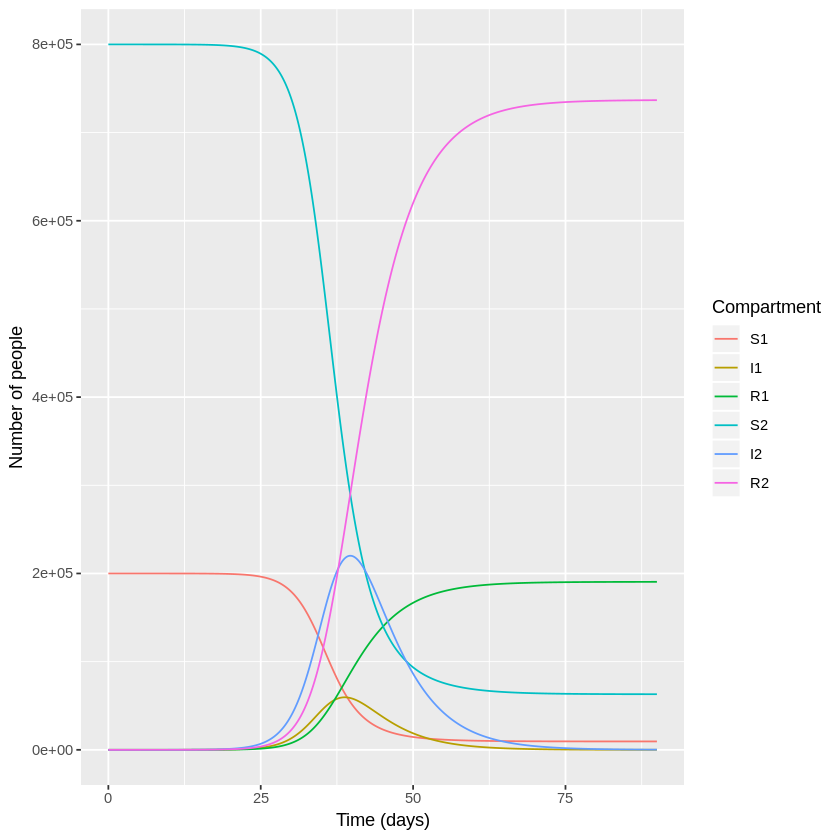

In [1]:
# PACKAGES
require(deSolve)
require(reshape2)
require(ggplot2)

# INPUT
# Initial state values for a naive population (everyone is susceptible except for 1 index case),
# where the total population size N is (approximately) 1 million and 20% of this are children
initial_state_values <- c(S1 = 200000,   # 20% of the population are children - all susceptible
                          I1 = 1,        # the outbreak starts with 1 infected person (can be either child or adult)  
                          R1 = 0,
                          S2 = 800000,   # 100%-20% of the population are adults - all susceptible
                          I2 = 0,
                          R2 = 0)

# Parameters
parameters <- c(b = 0.05,     # the probability of infection per contact is 5%
                c_11 = 7,     # daily number of contacts that children make with each other
                c_12 = 6,     # daily number of contacts that children make with adults
                c_21 = 1,     # daily number of contacts that adults make with children
                c_22 = 10,    # daily number of contacts that adults make with each other
                gamma = 1/5)  # the rate of recovery is 1/5 per day

# Run simulation for 3 months
times <- seq(from = 0, to = 90, by = 0.1)

# MODEL FUNCTION
sir_age_model <- function(time, state, parameters) {  
  
  with(as.list(c(state, parameters)), {
    
    N1 <- S1+I1+R1  # the total number of children in the population
    N2 <- S2+I2+R2  # the total number of adultsin the population
    
    # Defining the force of infection
    
    # Force of infection acting on susceptible children:
    lambda_1 <- b * c_11 * I1/N1 + b * c_12 * I2/N2   
    # Force of infection acting on susceptible adults:
    lambda_2 <- b * c_21 * I1/N1 + b * c_22 * I2/N2
    
    # The differential equations
    # Rate of change in children:
    dS1 <- -lambda_1 * S1               
    dI1 <- lambda_1 * S1 - gamma * I1
    dR1 <- gamma * I1
    # Rate of change in adults:
    dS2 <- -lambda_2 * S2            
    dI2 <- lambda_2 * S2 - gamma * I2
    dR2 <- gamma * I2   
    
    # Output
    return(list(c(dS1, dI1, dR1, dS2, dI2, dR2))) 
  })
}
    
    
# MODEL OUTPUT

output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_age_model,
                            parms = parameters))

# Turn output into long format
output_long <- melt(as.data.frame(output), id = "time") 

# Plot number of people in all compartments over time
ggplot(data = output_long,                                               
       aes(x = time, y = value, colour = variable, group = variable)) +  
  geom_line() +                                                          
  xlab("Time (days)")+                                                   
  ylab("Number of people") +                                
  labs(colour = "Compartment")                                           

### What was the cumulative incidence of infection during this epidemic? What proportion of those infections occurred in children?

In the SIR model, the cumulative incidence of infection is simply the decline in susceptibility.

In [2]:
# Calculate cumulative incidence as the number susceptible at the beginning of the epidemic minus the number 
# remaining susceptible at the end
print("Total cumulative incidence:")
(output$S1[1]-output$S1[nrow(output)])+(output$S2[1]-output$S2[nrow(output)])
# Cumulative incidence in children + cumulative incidence in adults
print("Proportion of infections in children:")
(output$S1[1]-output$S1[nrow(output)])/(output$S1[1]-output$S1[nrow(output)]+output$S2[1]-output$S2[nrow(output)])

[1] "Total cumulative incidence:"


[1] 927447.3

[1] "Proportion of infections in children:"


[1] 0.2054139

927,447 people became infected during this epidemic, 20.5% of which were children.

### Which age group was most affected by the epidemic?

To answer this, we can calculate the proportion of children and adults that became infected.

In [3]:
print("Proportion of children that became infected:")
(output$S1[1]-output$S1[nrow(output)])/200001

print("Proportion of adults that became infected:")
(output$S2[1]-output$S2[nrow(output)])/800001

[1] "Proportion of children that became infected:"


[1] 0.9525479

[1] "Proportion of adults that became infected:"


[1] 0.9211698

Over the course of this epidemic, 95% of all children and 92% of all adults were infected. Children were therefore slightly more affected in proportion to their population size, even though the majority of infections occurred in adults.